In [1]:
baseDir = '/oak/stanford/groups/shenoy/fwillett/speechPaperRelease_final/'

In [2]:
import scipy.io
subtractMeansWithinBlock = False

phonemesDat = scipy.io.loadmat(baseDir+'tuningTasks/t12.2022.04.21_phonemes.mat')
orofacialDat = scipy.io.loadmat(baseDir+'tuningTasks/t12.2022.04.21_orofacial.mat')
changDat = scipy.io.loadmat(baseDir+'tuningTasks/t12.2022.05.03_fiftyWordSet.mat')

In [4]:
#mean-subtract within block
import numpy as np
def meanSubtract(dat):
    dat['binnedTX'] = dat['binnedTX'].astype(np.float32)
    blockList = np.squeeze(np.unique(dat['blockNum']))
    for b in blockList:
        loopIdx = np.squeeze(dat['blockNum']==b)
        dat['binnedTX'][loopIdx,:] -= np.mean(dat['binnedTX'][loopIdx,:],axis=0,keepdims=True)
    return dat

In [5]:
import numpy as np
import scipy.stats
from scipy.ndimage import gaussian_filter1d
from numba import njit

@njit
def meanResamples(trlConcat):
    nResamples = 100
    resampleMeans = np.zeros((nResamples, trlConcat.shape[1], trlConcat.shape[2]))
    for rIdx in range(nResamples):
        resampleIdx = np.random.randint(0,trlConcat.shape[0],trlConcat.shape[0])
        resampleTrl = trlConcat[resampleIdx,:,:]
        resampleMeans[rIdx,:,:] = np.sum(resampleTrl, axis=0)/trlConcat.shape[0]

    return resampleMeans
    
def triggeredAvg(features, eventIdx, eventCodes, window, smoothSD=0):
    winLen = window[1]-window[0]
    codeList = np.unique(eventCodes)
    
    featAvg = np.zeros([len(codeList), winLen, features.shape[1]])
    featCI = np.zeros([len(codeList), winLen, features.shape[1], 2])
    allTrials = []
    
    for codeIdx in range(len(codeList)):
        print(codeIdx)
        trlIdx = np.squeeze(np.argwhere(eventCodes==codeList[codeIdx]))
        trlSnippets = []
        for t in trlIdx:
            if eventIdx[t]+window[1]>(features.shape[0]-1) or eventIdx[t]+window[0]<0:
                continue
            trlSnippets.append(features[(eventIdx[t]+window[0]):(eventIdx[t]+window[1]),:])
        
        trlConcat = np.stack(trlSnippets,axis=0)
        allTrials.append(trlConcat)
            
        if smoothSD>0:
            trlConcat = gaussian_filter1d(trlConcat, smoothSD, axis=1)

        featAvg[codeIdx,:,:] = np.mean(trlConcat, axis=0)
        
        tmp = np.percentile(meanResamples(trlConcat), [2.5, 97.5], axis=0)   
        featCI[codeIdx,:,:,:] = np.transpose(tmp,[1,2,0]) 
        
    return featAvg, featCI, allTrials


In [6]:
#mean subtraction
if subtractMeansWithinBlock:
    phonemesDat = meanSubtract(phonemesDat)
    orofacialDat = meanSubtract(orofacialDat)
    changDat = meanSubtract(changDat)

In [7]:
import scipy.stats
def makeTuningHeatmap(dat, sets, window):

    features = dat['tx2'].astype(np.float32)
    nFeat = features.shape[1]
    nTrials = dat['goTrialEpochs'].shape[0]
    nClasses = dat['cueList'].shape[1]
    
    trialVectors = np.zeros([nTrials, features.shape[1]])
    predVectors = np.zeros([nTrials, features.shape[1]])
    
    tuningR2 = np.zeros([nFeat, len(sets)])
    tuningPVal = np.zeros([nFeat, len(sets)])
    
    for t in range(nTrials):
        trialVectors[t,:] = np.mean(features[(dat['goTrialEpochs'][t,0]+window[0]):(dat['goTrialEpochs'][t,0]+window[1])], axis=0)
        
    #split observations into folds
    nFolds = 5
    heldOutIdx = []
    minPerFold = np.floor(trialVectors.shape[0]/nFolds).astype(np.int32)
    remainder = trialVectors.shape[0]-minPerFold*nFolds
    if remainder>0:
        currIdx = np.arange(0,(minPerFold+1)).astype(np.int32)
    else:
        currIdx = np.arange(0,minPerFold).astype(np.int32)

    for x in range(nFolds):
        heldOutIdx.append(currIdx.copy())
        currIdx += len(currIdx)
        if remainder!=0 and x==remainder:
            currIdx = currIdx[0:-1]

    for foldIdx in range(nFolds):
        meanVectors = np.zeros([nClasses, nFeat])
        for m in range(nClasses):
            trlIdx = np.squeeze(np.argwhere(np.squeeze(dat['trialCues']-1)==m))
            trlIdx = np.setdiff1d(trlIdx, heldOutIdx[foldIdx])
            meanVectors[m,:] = np.mean(trialVectors[trlIdx,:], axis=0)
            
        for t in heldOutIdx[foldIdx]:
            predVectors[t,:] = meanVectors[dat['trialCues'][t,0]-1,:]
  
    for setIdx in range(len(sets)):
        mSet = sets[setIdx]
        trlIdx = np.argwhere(np.in1d(np.squeeze(dat['trialCues']-1), mSet))
        SSTOT = np.sum(np.square(trialVectors[trlIdx,:]-np.mean(trialVectors[trlIdx,:],axis=0,keepdims=True)), axis=0)
        SSERR = np.sum(np.square(trialVectors[trlIdx,:]-predVectors[trlIdx,:]), axis=0)
        
        tuningR2[:,setIdx] = 1-SSERR/SSTOT
        
        groupVectors = []
        for m in mSet:
            trlIdx = np.argwhere(np.squeeze(dat['trialCues']-1)==m)
            groupVectors.append(trialVectors[trlIdx,:])
            
        fResults = scipy.stats.f_oneway(*groupVectors,axis=0)
        tuningPVal[:,setIdx] = fResults[1]

    return tuningR2, tuningPVal


In [8]:
oroCueSets = [[5,6,7,8],
              [9,10,11,12],
              [13,14,15,16,17,18],
              [19,20,21,22],
              [23,24,25,26,27,28],
              [29,30,31,32,33]]
phonemeSets = [[0,1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,
               28,29,30,31,32,33,34,35,36,37,38,39]]

In [9]:
tuningR2_oro, tuningPVal_oro = makeTuningHeatmap(orofacialDat, oroCueSets, [10,50])
tuningR2_phones, tuningPVal_phones = makeTuningHeatmap(phonemesDat, phonemeSets, [10,50])

tuningR2_all = np.concatenate([tuningR2_oro, tuningR2_phones], axis=1)
tuningPVal_all = np.concatenate([tuningPVal_oro, tuningPVal_phones], axis=1)

/tmp/ipykernel_48794/3287293726.py:50: RuntimeWarning: invalid value encountered in divide
  tuningR2[:,setIdx] = 1-SSERR/SSTOT
/home/groups/shenoy/fwillett/code/speechRelease/lib/python3.9/site-packages/scipy/stats/_stats_py.py:3895: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


In [10]:
fAvg_phones, fCI_phones, trials_phones = triggeredAvg(phonemesDat['tx2'].astype(np.float32), 
                         phonemesDat['goTrialEpochs'][:,0],
                         np.squeeze(phonemesDat['trialCues']), [-100,100], smoothSD=4)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


In [11]:
fAvg_orofacial, fCI_orofacial, trials_orofacial = triggeredAvg(orofacialDat['tx2'].astype(np.float32), 
                         orofacialDat['goTrialEpochs'][:,0],
                         np.squeeze(orofacialDat['trialCues']), [-100,100], smoothSD=4)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33


In [12]:
fAvg_chang, fCI_chang, trials_chang = triggeredAvg(changDat['tx2'].astype(np.float32), 
                         changDat['goTrialEpochs'][:,0],
                         np.squeeze(changDat['trialCues']), [-100,100], smoothSD=4)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


In [13]:
print(trials_chang[2].shape)
print(trials_orofacial[2].shape)
print(trials_phones[2].shape)

(20, 200, 256)
(20, 200, 256)
(16, 200, 256)


In [14]:
changDat['cueList'][0,[4,7,20,31]]

array([array(['bring'], dtype='<U5'),
       array(['comfortable'], dtype='<U11'), array(['help'], dtype='<U4'),
       array(['need'], dtype='<U4')], dtype=object)

In [15]:
eyebrowSet = [5,6,7,8]
eyeSet = [9,10,11,12]
jawSet = [13,14,17,18]
larynxSet = [19,20,21,22]
lipsSet = [23,24,27,28]
tongueSet = [29,30,31,32]
orofacialSets = [eyebrowSet, eyeSet, jawSet, lipsSet, tongueSet, larynxSet]
phonemeSet = [0,5,30,39]
changSet = [4,7,20,31]

setTitles = ['Forehead','Eyelids','Jaw','Lips','Tongue','Larynx','Phonemes','Words']

channelIdx = 69 #52, 69
timeAxis = np.arange(-100,100)*0.02

legends = [['Furrow','Raise','Raise Left','Raise Right'],
       ['Close','Open Wide','Wink Left','Wink Right'],
       ['Jaw Clench','Jaw Drop','Jaw Left','Jaw Right'],
       ['Frown','Pucker','Smile','Tuck'],
       ['Tongue Down','Tongue Up','Tongue Left','Tongue Right'],
       ['Hum High','Hum Loud','Hum Low','Hum Soft'],
       ['B','G','IH','AE'],
       ['Bring','Comfortable','Help','Need']]

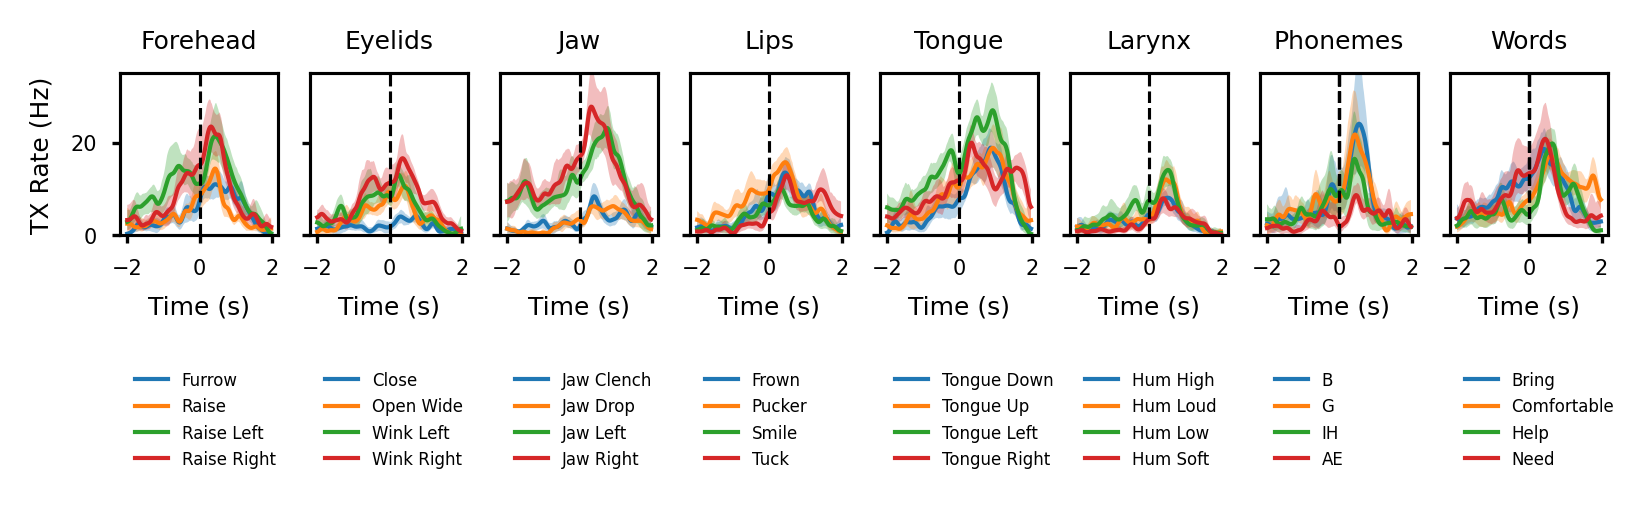

In [16]:
import matplotlib.pyplot as plt

SMALL_SIZE=5
MEDIUM_SIZE=6
BIGGER_SIZE=7

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['svg.fonttype'] = 'none'

if subtractMeansWithinBlock:
    yLimit = [-10,25]
else:
    yLimit = [0,35]
    
plt.figure(figsize=(len(setTitles)*(4/5),0.7), dpi=300)
for setIdx in range(len(orofacialSets)):
    conIdx = orofacialSets[setIdx]
    plt.subplot(1,len(orofacialSets)+2,setIdx+1)
    lines = []
    for c in range(len(conIdx)):
        tmp = plt.plot(timeAxis, 50*fAvg_orofacial[conIdx[c], :, channelIdx],linewidth=1)
        lines.append(tmp[0])
        plt.fill_between(timeAxis, 
                         50*fCI_orofacial[conIdx[c], :, channelIdx,0], 
                         50*fCI_orofacial[conIdx[c], :, channelIdx,1],alpha=0.3)
    plt.ylim(yLimit)
    plt.plot([0,0],plt.gca().get_ylim(),'--k',linewidth=0.75)
    if setIdx>0:
        plt.gca().set_yticklabels([])
    else:
        if subtractMeansWithinBlock:
            plt.ylabel('Δ TX Rate (Hz)')
        else:
            plt.ylabel('TX Rate (Hz)')    
    
    ax = plt.gca()
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.75)
    ax.tick_params(length=2)
    
    plt.xlabel('Time (s)')
    plt.title(setTitles[setIdx])
    plt.legend(lines,legends[setIdx],loc='upper left', bbox_to_anchor=(0.0, -0.75),fontsize=4,frameon=False)
    #plt.xlim([-0.5,1.0])
    
plt.subplot(1,len(orofacialSets)+2,len(orofacialSets)+1)
conIdx = phonemeSet
for c in range(len(conIdx)):
    plt.plot(timeAxis, 50*fAvg_phones[conIdx[c], :, channelIdx],linewidth=1)
    plt.fill_between(timeAxis, 
                 50*fCI_phones[conIdx[c], :, channelIdx,0], 
                 50*fCI_phones[conIdx[c], :, channelIdx,1],alpha=0.3)
    plt.ylim(yLimit)
    plt.plot([0,0],plt.gca().get_ylim(),'--k',linewidth=0.75)
    plt.title(setTitles[-2])
    plt.gca().set_yticklabels([])
    plt.xlabel('Time (s)')
    ax = plt.gca()
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.75)
    ax.tick_params(length=2)
    plt.legend(lines,legends[-2],loc='upper left', bbox_to_anchor=(0.0, -0.75),fontsize=4,frameon=False)
    
plt.subplot(1,len(orofacialSets)+2,len(orofacialSets)+2)
conIdx = changSet
for c in range(len(conIdx)):
    plt.plot(timeAxis, 50*fAvg_chang[conIdx[c], :, channelIdx],linewidth=1)
    plt.fill_between(timeAxis, 
                 50*fCI_chang[conIdx[c], :, channelIdx,0], 
                 50*fCI_chang[conIdx[c], :, channelIdx,1],alpha=0.3)
    plt.ylim(yLimit)
    plt.plot([0,0],plt.gca().get_ylim(),'--k',linewidth=0.75)
    plt.title(setTitles[-1])
    plt.gca().set_yticklabels([])
    plt.xlabel('Time (s)')
    ax = plt.gca()
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.75)
    ax.tick_params(length=2)
    plt.legend(lines,legends[-1],loc='upper left', bbox_to_anchor=(0.0, -0.75),fontsize=4,frameon=False)
    
plt.show()